<a href="https://colab.research.google.com/github/sudeepcodes/SelfAttentionUsingPytorch/blob/main/self_attention_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)

    attn_scores = torch.matmul(Q, torch.transpose(K, -2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    if mask is not None:
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

    attn_weights = F.softmax(attn_scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        # Define linear transformations for Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, x, mask=None):
        # Generate Q, K, V matrices
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Calculate attention using our scaled dot-product function
        out, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        return out, attention_weights

In [4]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

    def forward(self, x):
        return self.embedding(x)

In [6]:
class SimpleTokenizer:
    def __init__(self):
        self.word_to_idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx_to_word = {0: "<PAD>", 1: "<UNK>"}
        self.vocab_size = 2

    def fit(self, texts):
        # Build vocabulary from texts
        for text in texts:
            for word in text.split():
                if word not in self.word_to_idx:
                    self.word_to_idx[word] = self.vocab_size
                    self.idx_to_word[self.vocab_size] = word
                    self.vocab_size += 1

    def encode(self, text):
        # Convert text to token indices
        return [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in text.split()]

    def decode(self, indices):
        # Convert token indices back to text
        return [self.idx_to_word.get(idx, "<UNK>") for idx in indices]

In [7]:
def visualize_attention_heatmap(sentence, attention_weights, tokenizer):
    """
    Visualize the attention heatmap for a given sentence

    Args:
        sentence: Input sentence (string)
        attention_weights: Attention weights from the model (tensor of shape [seq_len, seq_len])
        tokenizer: Tokenizer used to process the sentence
    """
    # Convert to numpy for visualization
    attention_weights = attention_weights.detach().numpy()

    # Get tokens from the sentence
    tokens = sentence.split()

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attention_weights,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="YlGnBu",
        annot=True,
        fmt='.2f'
    )
    plt.title("Self-Attention Heatmap")
    plt.xlabel("Key/Value Tokens")
    plt.ylabel("Query Tokens")
    plt.tight_layout()
    plt.show()

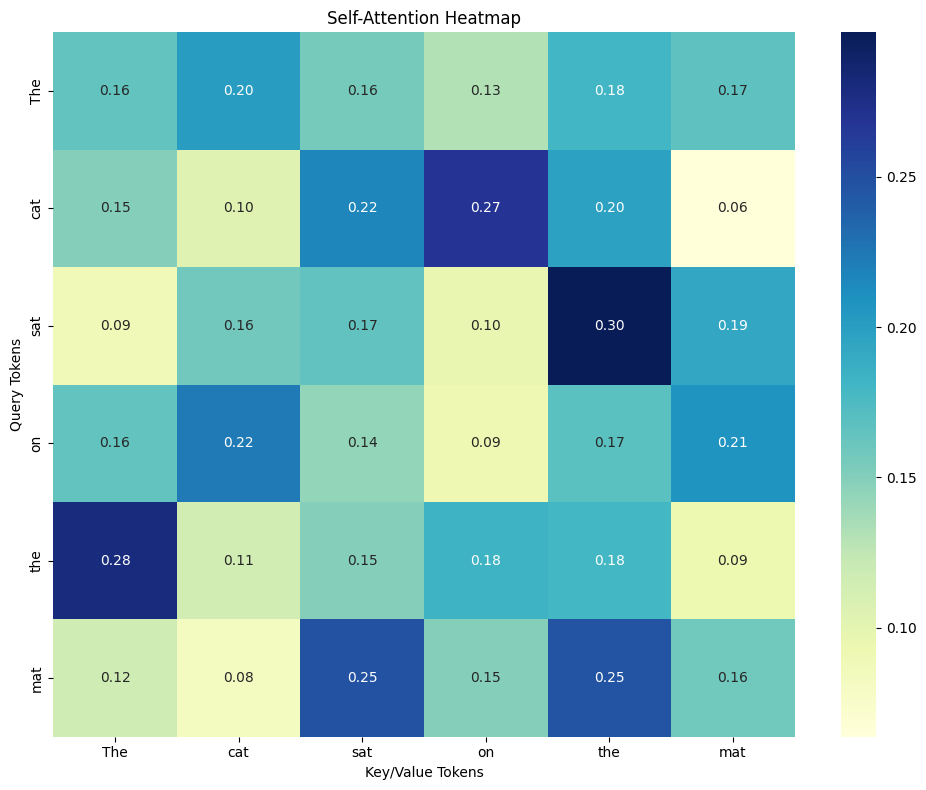

Attention shape: torch.Size([1, 6, 6])
Output shape: torch.Size([1, 6, 32])


In [8]:
# Example sentence
sentence = "The cat sat on the mat"

# Set up tokenizer and model
tokenizer = SimpleTokenizer()
tokenizer.fit([sentence])

# Define model parameters
embed_size = 32
vocab_size = tokenizer.vocab_size

# Create model components
embedding = TokenEmbedding(vocab_size, embed_size)
attention = SelfAttention(embed_size)

# Encode the sentence
token_ids = tokenizer.encode(sentence)
tokens_tensor = torch.tensor([token_ids], dtype=torch.long)

# Get embeddings
embedded = embedding(tokens_tensor)

# Get attention outputs
output, attention_weights = attention(embedded)

# Visualize attention for the first example in batch
# (shape: [batch_size, seq_len, seq_len] -> [seq_len, seq_len])
visualize_attention_heatmap(sentence, attention_weights[0], tokenizer)

print("Attention shape:", attention_weights.shape)
print("Output shape:", output.shape)